### Монтировка диска

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Импорты библиотек и объявление констант

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.layers import TimeDistributed, Dropout, Activation
from tensorflow.keras.layers import LSTM, MaxPooling1D, Masking, SimpleRNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras as keras
import numpy as np
import time
from enum import Enum

from argparse import ArgumentParser

SPEECH_PARTS = [
    'X',
    'ADJ',
    'ADV',
    'INTJ',
    'NOUN',
    'PROPN',
    'VERB',
    'ADP',
    'AUX',
    'CONJ',
    'SCONJ',
    'DET',
    'NUM',
    'PART',
    'PRON',
    'PUNCT',
    'GRND',
    'H',
    'R',
    'Q',
    'SYM',
]

SPEECH_PART_MAPPING = {str(s): num for num, s in enumerate(SPEECH_PARTS)}

MASK_VALUE = 0.0

MAX_LEN = 22

def build_speech_part_array(sp):
    output = [0. for _ in range(len(SPEECH_PARTS))]
    output[SPEECH_PART_MAPPING[str(sp)]] = 1.
    return output


CLASSES_NUM = [1, 3, 2, 4, 10, 9, 30, 86, 8, 7, 6, 17, 77, 37, 41, 90, 16, 34,
        28, 75, 64, 225, 12, 87, 14, 229, 43, 193, 38, 61, 35, 15, 53, 203, 68,
        236, 194, 230, 51, 39, 213, 231, 31, 33, 74, 209, 91, 96, 42, 204, 237,
        214, 88, 111, 18, 207, 69, 232, 5, 59, 97, 19, 60, 210, 89, 127, 169,
        274, 45, 106, 238, 47, 227, 240, 205, 208, 233, 57, 82, 46, 0]
# set([i for i in range(313 + 1)]) 

CLASS_NUM_MAPPING = {cn : num for num, cn in enumerate(CLASSES_NUM)}

def build_class_num_array(cn):
    output = [0. for _ in range(len(CLASSES_NUM))]
    output[CLASS_NUM_MAPPING[cn]] = 1.
    return output


PARTS_MAPPING = {
    'UNKN': 0,
    'PREF': 1,
    'ROOT': 2,
    'SUFF': 3,
    'END': 4,
    'LINK': 5,
    'HYPH': 6,
    'POSTFIX': 7,
    'B-SUFF': 8,
    'B-PREF': 9,
    'B-ROOT': 10,
}

LETTERS = {
    'о': 1,
    'е': 2,
    'а': 3,
    'и': 4,
    'н': 5,
    'т': 6,
    'с': 7,
    'р': 8,
    'в': 9,
    'л': 10,
    'к': 11,
    'м': 12,
    'д': 13,
    'п': 14,
    'у': 15,
    'я': 16,
    'ы': 17,
    'ь': 18,
    'г': 19,
    'з': 20,
    'б': 21,
    'ч': 22,
    'й': 23,
    'х': 24,
    'ж': 25,
    'ш': 26,
    'ю': 27,
    'ц': 28,
    'щ': 29,
    'э': 30,
    'ф': 31,
    'ъ': 32,
    'ё': 33,
    '-': 34,
}

VOWELS = {
    'а', 'и', 'е', 'ё', 'о', 'у', 'ы', 'э', 'ю', 'я'
}

### Классы `MorphemeLabel`,  `Morpheme`,  `Word`

In [ ]:
class MorphemeLabel(Enum):
    UNKN = 'UNKN'
    PREF = 'PREF'
    ROOT = 'ROOT'
    SUFF = 'SUFF'
    END = 'END'
    LINK = 'LINK'
    HYPH = 'HYPH'
    POSTFIX = 'POSTFIX'
    NONE = None


class Morpheme(object):
    def __init__(self, part_text, label, begin_pos):
        self.part_text = part_text
        self.length = len(part_text)
        self.begin_pos = begin_pos
        self.label = label
        self.end_pos = self.begin_pos + self.length

    def __len__(self):
        return self.length

    def get_labels(self):
        if self.length == 1:
            return ['S-' + self.label.value]
        result = ['B-' + self.label.value]
        result += ['M-' + self.label.value for _ in self.part_text[1:-1]]
        result += ['E-' + self.label.value]
        return result

    def get_simple_labels(self):
        if (self.label == MorphemeLabel.SUFF or self.label == MorphemeLabel.PREF or self.label == MorphemeLabel.ROOT):

            result = ['B-' + self.label.value]
            if self.length > 1:
                result += [self.label.value for _ in self.part_text[1:]]
            return result
        else:
            return [self.label.value] * self.length

    def __str__(self):
        return self.part_text + ':' + self.label.value

    def __eq__(self, other):
        return self.part_text == other.part_text and self.label == other.label

    def __hash__(self):
        return hash(tuple([self.part_text, self.label]))

    @property
    def unlabeled(self):
        return not self.label.value


class Word(object):
    def __init__(self, morphemes=[], speech_part='X', class_num=0):
        self.morphemes = morphemes
        self.sp = speech_part
        self.class_num = class_num

    def append_morpheme(self, morpheme):
        self.morphemes.append(morpheme)

    def get_word(self):
        return ''.join([morpheme.part_text for morpheme in self.morphemes])

    def parts_count(self):
        return len(self.morphemes)

    def morpheme_count(self, morph_label):
        return len([morpheme for morpheme in self.morphemes
                    if morpheme.label == morph_label])
    
    def morpheme_indexes(self, morph_label):
        return [i for i, morpheme in enumerate(self.morphemes)
                    if morpheme.label == morph_label]

    def get_labels(self):
        result = []
        for morpheme in self.morphemes:
            result += morpheme.get_labels()
        return result

    def get_simple_labels(self):
        result = []
        for morpheme in self.morphemes:
            result += morpheme.get_simple_labels()
        return result

    def __str__(self):
        return '/'.join([str(morpheme) for morpheme in self.morphemes])

    def __len__(self):
        return sum(len(m) for m in self.morphemes)

    @property
    def unlabeled(self):
        return all(p.unlabeled for p in self.morphemes)

### Функции `parse_word()`, `divide_word()`

In [ ]:
def parse_morpheme(str_repr, position):
    text, label = str_repr.split(':')
    return Morpheme(text, MorphemeLabel[label], position)


def parse_word(str_repr):
    if not str_repr.strip():
        return None
    if str_repr.count('\t') == 3:
        wordform, word_parts, _, class_info = str_repr.split('\t')
        if 'ADJ' in class_info:
            sp = 'ADJ'
        elif 'VERB' in class_info:
            sp = 'VERB'
        elif 'NOUN' in class_info:
            sp = 'NOUN'
        elif 'GRND' in class_info:
            sp = 'GRND'
        elif 'ADV' in class_info:
            sp = 'ADV'
        elif 'PART' in class_info:
            sp = 'PART'
        else:
            raise Exception("Unknown class", class_info)
        
        class_num = int( class_info [class_info.rfind(" ") + 1 : class_info.rfind(")")] )
        if class_num not in CLASSES_NUM:
            class_num = 1  if sp != 'ADV' else 0

    elif str_repr.count('\t') == 2:
        wordform, word_parts, sp = str_repr.split('\t')
        sp, class_num = 'X', 1
    elif str_repr.count('\t') == 4:
        print(str_repr)
        return None
    else:
        wordform, word_parts = str_repr.split('\t')
        sp = 'X'

    if ':' in wordform or '/' in wordform:
        return None

    parts = word_parts.split('/')
    morphemes = []
    global_index = 0
    for part in parts:
        morphemes.append(parse_morpheme(part, global_index))
        global_index += len(part)
    return Word(morphemes, sp, class_num)
    


def divide_word(word):
    # Оставляем только слова-прилагательные с одним дефисом 
    if not (word.sp == 'ADJ' and word.morpheme_count(MorphemeLabel.HYPH) == 1):
        return []
    
    # Дробление слова по дефису
    i = word.morpheme_indexes(MorphemeLabel.HYPH) [0]
    # Оставляем только слова, у которых перед дефисом стоит морфема о:LINK
    if word.morphemes[i-1] != Morpheme('о', MorphemeLabel.LINK, 0):
        return []

    # sp = 'H' #слово перед дефисом - что-то типо наречия(обозначим как 'H')
    # morphemes1 = word.morphemes[:i+1] # берем вместе с дефисом
    sp = 'ADV' # слово перед дефисом - наречие
    end = Morpheme('o', MorphemeLabel.END, word.morphemes[i-1].begin_pos) # окончание наречие
    # sp = 'ADJ'
    # end = Morpheme('ый', MorphemeLabel.END, word.morphemes[i-1].begin_pos) # окончание прилагательного
    morphemes1 = word.morphemes[:i-1] + [end]
    morphemes2 = word.morphemes[i+1:]
    new_words = []
    if len(morphemes1) <= MAX_LEN and len(morphemes2) <= MAX_LEN:
        new_words.append(Word(morphemes1, sp, 0)) #1))
        new_words.append(Word(morphemes2, word.sp, word.class_num))
    
    return new_words

### Функции `_get_parse_repr()`, `_pad_sequences()`, `_prepare_words()`

In [ ]:
def _get_parse_repr(word):
    features = []
    word_text = word.get_word()
    for index, letter in enumerate(word_text):
        letter_features = []
        vowelty = int(letter in VOWELS)
        letter_code = LETTERS[letter]  if letter in LETTERS  else 0

        letter_features.append(vowelty)
        letter_features += to_categorical(letter_code, num_classes=len(LETTERS) + 1).tolist()
        letter_features += build_speech_part_array(word.sp)
        # letter_features += build_class_num_array(word.class_num)
        features.append(letter_features)

    X = np.array(features, dtype=np.int8)
    Y = np.array([to_categorical(PARTS_MAPPING[label], num_classes=len(PARTS_MAPPING)) for label in word.get_simple_labels()])
    return X, Y


def _pad_sequences(Xs, Ys, max_len):
    newXs = pad_sequences(Xs, padding='post', dtype=np.int8, maxlen=max_len, value=MASK_VALUE)
    newYs = pad_sequences(Ys, padding='post', maxlen=max_len, value=MASK_VALUE)
    return newXs, newYs


def _prepare_words(words, max_len, verbose=True):
    result_x, result_y = [], []
    if verbose:
        print("Preparing words")
    for i, word in enumerate(words):
        word_x, word_answer = _get_parse_repr(word)
        result_x.append(word_x)
        result_y.append(word_answer)
        if i % 1000 == 0 and verbose:
            print("Prepared", i)
    if verbose:
        print("Preparing words finished.")

    return _pad_sequences(result_x, result_y, max_len)

### Функция `measure_quality()`

In [ ]:
def measure_quality(predicted_targets, targets, words, verbose=False, hyphen=False):
    TP, FP, FN, equal, total = 0, 0, 0, 0, 0
    SE = ['{}-{}'.format(x, y) for x in "SE" for y in ["ROOT", "PREF", "SUFF", "END", "LINK", "None"]]
    corr_words = 0
    prev_corr, prev_pred, prev_word = '', '', ''
    for corr, pred, word in zip(targets, predicted_targets, words):
        corr_len = len(corr)
        pred_len = len(pred)
        boundaries = [i for i in range(corr_len) if corr[i] in SE]
        pred_boundaries = [i for i in range(pred_len) if pred[i] in SE]
        common = [x for x in boundaries if x in pred_boundaries]
        TP += len(common)
        FN += len(boundaries) - len(common)
        FP += len(pred_boundaries) - len(common)
        equal += sum(int(x == y) for x, y in zip(corr, pred))
        total += len(corr)

        if hyphen and prev_word == '':
            #if word.morphemes[-1] == Morpheme('о', MorphemeLabel.LINK, 0):
            pred[-1] = 'S-LINK' # меняем вручную метку последней буквы
            corr[-1] = 'S-LINK'
            #corr = corr[:-2] + ['S-LINK']
            #pred = pred[:-2] + ['S-LINK']
            prev_corr, prev_pred, prev_word = corr, pred, word
            continue
        elif hyphen:
            corr_words += (corr == pred and prev_corr == prev_pred)
        else:
            corr_words += (corr == pred)
        
        if hyphen and (corr != pred or prev_corr != prev_pred) and verbose:
            w, pw = word.get_word(), prev_word.get_word()
            print(f"Error in word '{pw+'-'+w}':\n correct:", list(zip(pw+'-'+w, prev_corr+['S-HYPH']+corr)), 
                  '\n!=\n wrong: ', list(zip(pw+'-'+w, prev_pred+['S-HYPH']+pred)), end='\n\n')
        
        elif corr != pred and verbose:
            w = word.get_word()
            print("Error in word '{}':\n correct:".format(w), list(zip(w, corr)), '\n!=\n wrong: ', list(zip(w, pred)), end='\n\n')
        
        prev_corr, prev_pred, prev_word = '', '', ''

    metrics = ["Precision", "Recall", "F1", "Accuracy", "Word accuracy"]
    results = [TP / (TP+FP), TP / (TP+FN), TP / (TP + 0.5*(FP+FN)),
               equal / total, corr_words / len(targets)]
    if hyphen:
        results[-1] = corr_words / (len(targets) // 2)

    return list(zip(metrics, results))

### Класс **`Attention`**

*Many-to-one attention mechanism for Keras.*
![png](https://raw.githubusercontent.com/philipperemy/keras-attention-mechanism/master/examples/equations.png)

* ***`s`*** is the encoder index.
* ***`t`*** is the decoder index.
* ***`αₜₛ`*** is the attention weights.
* ***`hₛ`*** is the sequence of encoder outputs being attended to (the attention "key" and "value" in transformer terminology).
* ***`hₜ`*** is the the decoder state attending to the sequence (the attention "query" in transformer terminology).
* ***`cₜ`*** is the resulting context vector.
* ***`aₜ`*** is the final output combining the "context" and "query".

The equations:

1. Calculates the attention weights, ***`αₜₛ`***, as a softmax across the 
encoder's output sequence.
2. Calculates the context vector as the weighted sum of the encoder outputs.

Last is the ***`score`*** function. Its job is to calculate a scalar logit-score for each key-query pair. There are two common approaches on the picture.

In [ ]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K


class Attention(Layer):
    
    def __init__(self, units=32, return_sequences=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.return_sequences = return_sequences
        self.units = units
        self.supports_masking = True
        
    def build(self, input_shape):
        
        self.Wt = self.add_weight(name="att_weight_t", shape=(input_shape[-1], self.units),
                               initializer="glorot_normal", trainable=True)
        self.Wx = self.add_weight(name="att_weight_x", shape=(input_shape[-1], self.units),
                               initializer="glorot_normal", trainable=True)
        self.Wa = self.add_weight(name="att_weight_a", shape=(self.units, 1),
                               initializer="glorot_normal", trainable=True)
        self.bh = self.add_weight(name="att_bias_h", shape=(self.units,), #(input_shape[1], self.units),
                               initializer="zeros", trainable=True)
        self.ba = self.add_weight(name="att_bias_a", shape=(1,),
                               initializer="zeros", trainable=True)
        
        super(Attention, self).build(input_shape)
    
    def call(self, x, mask=None):
        # Alignment scores. Pass them through tanh function
        # h_{t, t'} = \tanh(x_t^T W_t + x_{t'}^T W_x + b_h)
        q = K.expand_dims(K.dot(x, self.Wt), 2)
        # (None, 22, 1536) x (1536, 32) = (None, 22, 32)
        # expand_dims((None, 22, 32), 2) = (None, 22, 1, 32)
        k = K.expand_dims(K.dot(x, self.Wx), 1)
        # (None, 22, 1536) x (1536, 32) = (None, 22, 32)
        # expand_dims((None, 22, 32), 2) = (None, 1, 22, 32)
        h = K.tanh(q + k + self.bh)
        # (None, 22, 1, 32) + (None, 1, 22, 32) + (32,) = (None, 22, 22, 32)
 
        # e_{t, t'} = W_a h_{t, t'} + b_a
        e = K.reshape(K.dot(h, self.Wa) + self.ba, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[1]))
        # ((None, 22, 22, 32) x (32, 1)) + (1,) = (None, 22, 22, 1) + (1,) = (None, 22, 22, 1)
        # reshape((None, 22, 22, 1), (None, 22, 22)) = (None, 22, 22)

        # Compute the weights
        a = K.softmax(e, axis=1)
        # a = (None, 22, 22)

        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano, and expand_dims -> to 3 dimensions
            mask = K.expand_dims(K.cast(mask, K.floatx()), axis=-1)
            a *= mask
            # (None, 22, 22) * (None, 22, 1) = (None, 22, 22)

        # Compute the context vector
        output = K.batch_dot(a, x) # x*a
        # (None, 22, 22) batch_dot (None, 22, 1536) = (None, 22, 1536)

        if self.return_sequences:
            return output
        return K.sum(output, axis=1)
        """
        x.shape = (None, 22, 1536)
        self.W.shape = (1536, 128)
        self.b.shape = (22, 128)

        K.dot(x, self.W).shape = (None, 22, 128)
        e.shape = (None, 22, 128)

        a.shape = (None, 22, 128

        mask.shape = (None, 22, 1)
        a.shape after mask = (None, 22, 128) # (None, 22, 1) - if units=1
        """


    def get_config(self):
        # calls the configuration method of its parent
        config = super().get_config().copy()
        # and defines custom attributes introduced with the layer
        config.update({'return_sequences': self.return_sequences,
                       'units': self.units
                       })
        return config

    @staticmethod
    def get_custom_objects():
        return {'Attention': Attention}

### Класс `MorphemModel`:

* `__init__()`
* `_transform_classification()`
* `_build_model()`
* `train()`
* `load()`
* `classify()`
* `measure_time_batch`


In [ ]:
class MorphemModel(object):
    def __init__(self, dropout, layers, models_number, epochs, validation_split, window_sizes, max_len):
        self.dropout = dropout
        self.layers = layers
        self.models_number = models_number
        self.epochs = epochs
        self.validation_split = validation_split
        self.window_sizes = window_sizes
        self.activation = "softmax"
        self.optimizer = "adam"
        self.models = []
        self.max_len = max_len

    def _transform_classification(self, parse):
        parts = []
        current_part = [parse[0]]
        for num, letter in enumerate(parse[1:]):
            index = num + 1
            if letter == 'SUFF' and parse[index - 1] == 'B-SUFF':
                current_part.append(letter)
            elif letter == 'PREF' and parse[index - 1] == 'B-PREF':
                current_part.append(letter)
            elif letter == 'ROOT' and parse[index - 1] == 'B-ROOT':
                current_part.append(letter)
            elif letter != parse[index - 1] or letter.startswith('B-'):
                parts.append(current_part)
                current_part = [letter]
            else:
                current_part.append(letter)
        if current_part:
            parts.append(current_part)

        for part in parts:
            if part[0] == 'B-PREF':
                part[0] = 'PREF'
            if part[0] == 'B-SUFF':
                part[0] = 'SUFF'
            if part[0] == 'B-ROOT':
                part[0] = 'ROOT'
            if len(part) == 1:
                part[0] = 'S-' + part[0]
            else:
                part[0] = 'B-' + part[0]
                part[-1] = 'E-' + part[-1]
                for num, letter in enumerate(part[1:-1]):
                    part[num+1] = 'M-' + letter
        result = []
        for part in parts:
            result += part
        return result

    def _build_model(self, input_maxlen):
        #inp = Input(shape=(input_maxlen, len(LETTERS) + 1 + 1 + len(CLASSES_NUM) + len(SPEECH_PARTS)))
        inp = Input(shape=(input_maxlen, len(LETTERS) + 1 + 1 + len(SPEECH_PARTS)), name="input")
        #mask = Masking(mask_value=[MASK_VALUE] * (len(LETTERS) + 1 + 1 + lemn(SPEECH_PARTS))) (inp)
        mask = Masking(mask_value=MASK_VALUE).compute_mask (inp)
        inputs = [inp]
        do = None
        
        conv_outputs = []
        for i, (drop, units, window_size) in enumerate(zip(self.dropout, self.layers, self.window_sizes)):
            conv = Conv1D(units, window_size, activation='relu', padding="same", name=f"convolution_{i+1}") (inp)
            do = Dropout(drop, name=f"dropout_{i+1}") (conv)
            #pool = MaxPooling1D(pool_size=4, strides=1, padding='same') (do)
            inp = do
            conv_outputs.append (do)

        #concat = Concatenate(name="concatenate") (conv_outputs)
        #pool = MaxPooling1D(pool_size=4, strides=1, padding='same') (concat)
        #lstm = LSTM(128, return_sequences=True, name="lstm") (concat) #, mask=mask) #dropout=0.4

        attention = Attention(return_sequences=True, name="attention") (conv_outputs[-1], mask=mask) #(concat, mask=mask) 

        outputs = [TimeDistributed(
            #Dense(len(PARTS_MAPPING), activation=self.activation)) (lstm)]#(concat, mask=mask)] 
            Dense(len(PARTS_MAPPING), activation=self.activation), name="time_distributed") (attention)] #(lstm)]
  

        self.models.append(Model(inputs, outputs=outputs))
        self.models[-1].compile(loss='categorical_crossentropy',
                                optimizer=self.optimizer, metrics=['acc'])

        print(self.models[-1].summary())

    def train(self, words, validation, x, y, val_x, val_y):
        #(x, y,) = _prepare_words(words, self.max_len)
        #(val_x, val_y) = _prepare_words(validation, self.max_len)
        for i in range(self.models_number):
            self._build_model(self.max_len)
        
        es = EarlyStopping(monitor='val_acc', patience=10, verbose=1)
        cp = ModelCheckpoint("/content/drive/MyDrive/morph_model/keras_morphem_model_checkpoint_{}.h5".format(int(time.time())), \
                             monitor='val_acc', verbose=0, save_best_only=True, mode='max') #save_weights_only=True)
        
        history = self.models[-1].fit(x, y, epochs=self.epochs, verbose=1,
                            callbacks=[es, cp], validation_data=(val_x, val_y), batch_size=4096) #batch_size=8192)
        self.models[-1].save("/content/drive/MyDrive/morph_model/keras_morphem_model_{}.h5".format(int(time.time())))

        return history

    def load(self, path):
        self.models.append(keras.models.load_model(path, custom_objects=Attention.get_custom_objects()))
        print(self.models[-1].summary())

    def classify(self, words, x):
        print("Total models:", len(self.models))
        #(x, _,) = _prepare_words(words, self.max_len)
        pred = self.models[-1].predict(x)
        pred_class = pred.argmax(axis=-1)
        reverse_mapping = {v: k for k, v in PARTS_MAPPING.items()}
        result = []
        for i, word in enumerate(words):
            cutted_prediction = pred_class[i][:len(word.get_word())]
            raw_parse = [reverse_mapping[int(num)] for num in cutted_prediction]
            # print(raw_parse)  ->  ['B-ROOT', 'ROOT', 'ROOT', 'ROOT', 'LINK', 'B-ROOT', 'ROOT', 'ROOT', 'ROOT', 'ROOT', 'ROOT', 'ROOT', 'END']
            parse = self._transform_classification(raw_parse)
            # print(parse)      ->  ['B-ROOT', 'M-ROOT', 'M-ROOT', 'E-ROOT', 'S-LINK', 'B-ROOT', 'M-ROOT', 'M-ROOT', 'M-ROOT', 'M-ROOT', 'M-ROOT', 'E-ROOT', 'S-END']
            result.append(parse)
        return result

    def measure_time_batch(self, words, batch_size):
        def chunks(lst, n):
            for i in range(0, len(lst), n):
                yield lst[i:i + n]

        reverse_mapping = {v: k for k, v in PARTS_MAPPING.items()}
        batch_times = []
        for t in range(1):
            total_time = 0
            for j, words_chunk in enumerate(chunks(words, batch_size)):
                (x, _,) = _prepare_words(words_chunk, self.max_len, False)
                start_time = time.time()
                pred = self.models[-1].predict(x)
                pred_class = pred.argmax(axis=-1)
                for i, word in enumerate(words_chunk):
                    cutted_prediction = pred_class[i][:len(word.get_word())]
                    raw_parse = [reverse_mapping[int(num)] for num in cutted_prediction]
                    parse = self._transform_classification(raw_parse)
                finish_time = time.time()
                batch_time = finish_time - start_time
                total_time += batch_time
            batch_times.append(total_time)
        return batch_times

### `main()` - Подготовка обучающего датасета

In [ ]:
if __name__ == "__main__":

    train_set = "/content/drive/MyDrive/morph_model/new_new_new/tikhonov_lexemes_lexeme_group.train"
    # "/content/drive/MyDrive/morph_model/lexeme/tikhonov_lexemes_lexeme_group0.train"
    # "/content/drive/MyDrive/morph_model/new/tikhonov_lexemes_lexeme_group.train"
    val_set = "/content/drive/MyDrive/morph_model/new_new_new/tikhonov_lexemes_lexeme_group.val" 
    # "/content/drive/MyDrive/morph_model/lexeme/tikhonov_lexemes_lexeme_group0.val"
    # "/content/drive/MyDrive/morph_model/new/tikhonov_lexemes_lexeme_group.val" 


    long_words, train_part = [], []
    counter, max_len = 0, 0
    if train_set:
        with open(train_set, 'r') as data:
            for num, line in enumerate(data):
                counter += 1
                word = parse_word(line.strip())
                if word is None: 
                    continue
                if len(word) <= MAX_LEN:
                    train_part.append(word)
                else:
                    long_words.append(word)
                    for word in divide_word(word):
                        train_part.append(word)
                #max_len = max(max_len, len(train_part[-1]))
                if counter % 1000 == 0:
                    print("Loaded", counter, "train words")
                #if counter == 2000: break


    validation_part = []
    if val_set:
        with open(val_set, 'r') as data:
            for num, line in enumerate(data):
                counter += 1
                word = parse_word(line.strip())
                if word is None:
                    continue
                if len(word) <= MAX_LEN:
                    validation_part.append(word)
                else:
                    long_words.append(word)
                    for word in divide_word(word):
                        validation_part.append(word)
                if counter % 1000 == 0:
                    print("Loaded", counter, "train words")
                #if counter == 3000: break


    max_len = MAX_LEN

    hyphen_long_words = list(filter(lambda word: word.morpheme_count(MorphemeLabel.HYPH) > 0, long_words))
    
    print(f"\nКоличество длинных слов(len>{max_len}): {len(long_words)} \
({len(long_words) / (len(long_words) + len(train_part) + len(validation_part)) * 100 :.2f}% от общей выборки)")
    print(f"Количество длинных слов через дефис: {len(hyphen_long_words)} \
({len(hyphen_long_words) / (len(long_words) + len(train_part) + len(validation_part)) * 100 :.2f}% от общей выборки, \
{len(hyphen_long_words) / len(long_words) * 100 :.2f}% от всех длинных слов)")
    #print(f"Количество слов через дефис: {len(hyphen_words)} ({len(hyphen_words) / (len(long_words) + len(hyphen_words) + len(train_part) + len(validation_part)) * 100 :.2f}% от общей выборки)")
    
    print("number of train_part words:", len(train_part), ", number of validation_part words:", len(validation_part))

Loaded 1000 train words
Loaded 2000 train words
Loaded 3000 train words
Loaded 4000 train words
Loaded 5000 train words
Loaded 6000 train words
Loaded 7000 train words
Loaded 8000 train words
Loaded 9000 train words
Loaded 10000 train words
Loaded 11000 train words
Loaded 12000 train words
Loaded 13000 train words
Loaded 14000 train words
Loaded 15000 train words
Loaded 16000 train words
Loaded 17000 train words
Loaded 18000 train words
Loaded 19000 train words
Loaded 20000 train words
Loaded 21000 train words
Loaded 22000 train words
Loaded 23000 train words
Loaded 24000 train words
Loaded 25000 train words
Loaded 26000 train words
Loaded 27000 train words
Loaded 28000 train words
Loaded 29000 train words
Loaded 30000 train words
Loaded 31000 train words
Loaded 32000 train words
Loaded 33000 train words
Loaded 34000 train words
Loaded 35000 train words
Loaded 36000 train words
Loaded 37000 train words
Loaded 38000 train words
Loaded 39000 train words
Loaded 40000 train words
Loaded 41

In [ ]:
    (x, y) = _prepare_words(train_part, max_len)
    (val_x, val_y) = _prepare_words(validation_part, max_len)

Preparing words
Prepared 0
Prepared 1000
Prepared 2000
Prepared 3000
Prepared 4000
Prepared 5000
Prepared 6000
Prepared 7000
Prepared 8000
Prepared 9000
Prepared 10000
Prepared 11000
Prepared 12000
Prepared 13000
Prepared 14000
Prepared 15000
Prepared 16000
Prepared 17000
Prepared 18000
Prepared 19000
Prepared 20000
Prepared 21000
Prepared 22000
Prepared 23000
Prepared 24000
Prepared 25000
Prepared 26000
Prepared 27000
Prepared 28000
Prepared 29000
Prepared 30000
Prepared 31000
Prepared 32000
Prepared 33000
Prepared 34000
Prepared 35000
Prepared 36000
Prepared 37000
Prepared 38000
Prepared 39000
Prepared 40000
Prepared 41000
Prepared 42000
Prepared 43000
Prepared 44000
Prepared 45000
Prepared 46000
Prepared 47000
Prepared 48000
Prepared 49000
Prepared 50000
Prepared 51000
Prepared 52000
Prepared 53000
Prepared 54000
Prepared 55000
Prepared 56000
Prepared 57000
Prepared 58000
Prepared 59000
Prepared 60000
Prepared 61000
Prepared 62000
Prepared 63000
Prepared 64000
Prepared 65000
Prepare

### Создание и обучение модели / загрузка модели из файла

In [ ]:
    max_len = MAX_LEN
    model = MorphemModel([0.4, 0.4, 0.4], [512, 512, 512], 1, 60, 0.1, [5, 5, 5], max_len)
    #model = MorphemModel([0.4, 0.4], [512, 512], 1, 60, 0.1, [5, 5], max_len)
    model_path = "/content/drive/MyDrive/morph_model/new_attention32_withoutPos_withoutConcat.h5"
    # "/content/drive/MyDrive/morph_model/attention32_checkpoint.h5"
    # "/content/drive/MyDrive/morph_model/attention32.h5"
    # "/content/drive/MyDrive/morph_model/lstm128_checkpoint.h5"
    # train_part = []
    if train_part:
        print("Training model")
        history = model.train(train_part, validation_part, x, y, val_x, val_y)
    else:
        print("Loading model")
        model.load(model_path)

Loading model
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 22, 36)]     0           []                               
                                                                                                  
 convolution_1 (Conv1D)         (None, 22, 512)      92672       ['input[0][0]']                  
                                                                                                  
 dropout_1 (Dropout)            (None, 22, 512)      0           ['convolution_1[0][0]']          
                                                                                                  
 convolution_2 (Conv1D)         (None, 22, 512)      1311232     ['dropout_1[0][0]']              
                                                                                

### Подготовка тестового датасета

In [ ]:
    test_lemma_set = "/content/drive/MyDrive/morph_model/lexeme/tikhonov_lexemes_lemma_group0.test"
    #"/content/drive/MyDrive/morph_model/new_new_new/tikhonov_lexemes_lemma_group.test"
    #"/content/drive/MyDrive/morph_model/lexeme/tikhonov_lexemes_lemma_group0.test"
    # "/content/drive/MyDrive/morph_model/new/tikhonov_lexemes_lemma_group.test"
    # "/content/drive/MyDrive/morph_model/lemma/tikhonov_lexemes_lemma_group.test"
    test_lexeme_set = "/content/drive/MyDrive/morph_model/lexeme/tikhonov_lexemes_lexeme_group0.test"
    #"/content/drive/MyDrive/morph_model/new_new_new/tikhonov_lexemes_lexeme_group.test"
    # "/content/drive/MyDrive/morph_model/lexeme/tikhonov_lexemes_lexeme_group0.test"
    # "/content/drive/MyDrive/morph_model/new/tikhonov_lexemes_lexeme_group.test"
    
    long_words = []
    counter = 0
    test_lexeme_part = []
    if test_lexeme_set:
        with open(test_lexeme_set, 'r') as data:
            for num, line in enumerate(data):
                counter += 1
                word = parse_word(line.strip())  if line.strip() != "" else None
                if word is None:
                    continue
                if len(word) <= MAX_LEN:
                    test_lexeme_part.append(word)
                else:
                    long_words.append(word)
                    #for word in divide_word(word):
                    #    test_lexeme_part.append(word)
                if counter % 1000 == 0:
                    print("Loaded", counter, "test words")

    hyphen_long_words = list(filter(lambda word: word.morpheme_count(MorphemeLabel.HYPH) > 0, long_words))
    long_words_lex = long_words
    hyphen_long_words_lex = hyphen_long_words
    
    print(f"\nКоличество длинных слов(len>{max_len}): {len(long_words)} \
({len(long_words) / (len(long_words) + len(test_lexeme_part)) * 100 :.2f}% от общей выборки)")
    print(f"Количество длинных слов через дефис: {len(hyphen_long_words)} \
({len(hyphen_long_words) / (len(long_words) + len(test_lexeme_part)) * 100 :.2f}% от общей выборки, \
{len(hyphen_long_words) / len(long_words) * 100 :.2f}% от всех длинных слов)\n\n")
    
    
    long_words = []
    counter = 0
    test_lemma_part = []
    if test_lemma_set:
        with open(test_lemma_set, 'r') as data:
            for num, line in enumerate(data):
                counter += 1
                word = parse_word(line.strip()) if line.strip() != "" else None
                if word is None:
                    continue
                if len(word) <= MAX_LEN:
                    test_lemma_part.append(word)
                else:
                    long_words.append(word)
                    #for word in divide_word(word):
                    #    test_lemma_part.append(word)
                if counter % 1000 == 0:
                    print("Loaded", counter, "test words")

    hyphen_long_words = list(filter(lambda word: word.morpheme_count(MorphemeLabel.HYPH) > 0, long_words))
    """
    print(f"\nКоличество длинных слов(len>{max_len}): {len(long_words)} \
({len(long_words) / (len(long_words) + len(test_lemma_part)) * 100 :.2f}% от общей выборки)")
    print(f"Количество длинных слов через дефис: {len(hyphen_long_words)} \
({len(hyphen_long_words) / (len(long_words) + len(test_lemma_part)) * 100 :.2f}% от общей выборки, \
{len(hyphen_long_words) / len(long_words) * 100 :.2f}% от всех длинных слов)")
    """
    print("number of test_lexeme_part words:", len(test_lexeme_part), ", number of test_lemma_part words:", len(test_lemma_part))

Loaded 1000 test words
Loaded 2000 test words
Loaded 3000 test words
Loaded 4000 test words
Loaded 5000 test words
Loaded 6000 test words
Loaded 7000 test words
Loaded 8000 test words
Loaded 9000 test words
Loaded 10000 test words
Loaded 11000 test words
Loaded 12000 test words
Loaded 13000 test words
Loaded 14000 test words
Loaded 15000 test words
Loaded 16000 test words
Loaded 17000 test words
Loaded 18000 test words
Loaded 19000 test words
Loaded 20000 test words
Loaded 21000 test words
Loaded 22000 test words
Loaded 23000 test words
Loaded 24000 test words
Loaded 25000 test words
Loaded 26000 test words
Loaded 27000 test words
Loaded 28000 test words
Loaded 29000 test words
Loaded 30000 test words
Loaded 31000 test words
Loaded 32000 test words
Loaded 33000 test words
Loaded 34000 test words
Loaded 35000 test words
Loaded 36000 test words
Loaded 37000 test words
Loaded 38000 test words
Loaded 39000 test words
Loaded 40000 test words
Loaded 41000 test words
Loaded 42000 test words
L

In [ ]:
    if test_lexeme_part:
        (x1, _,) = _prepare_words(test_lexeme_part, max_len)
    if test_lemma_part:
        (x2, _,) = _prepare_words(test_lemma_part, max_len)

Preparing words
Prepared 0
Prepared 1000
Prepared 2000
Prepared 3000
Prepared 4000
Prepared 5000
Prepared 6000
Prepared 7000
Prepared 8000
Prepared 9000
Prepared 10000
Prepared 11000
Prepared 12000
Prepared 13000
Prepared 14000
Prepared 15000
Prepared 16000
Prepared 17000
Prepared 18000
Prepared 19000
Prepared 20000
Prepared 21000
Prepared 22000
Prepared 23000
Prepared 24000
Prepared 25000
Prepared 26000
Prepared 27000
Prepared 28000
Prepared 29000
Prepared 30000
Prepared 31000
Prepared 32000
Prepared 33000
Prepared 34000
Prepared 35000
Prepared 36000
Prepared 37000
Prepared 38000
Prepared 39000
Prepared 40000
Prepared 41000
Prepared 42000
Prepared 43000
Prepared 44000
Prepared 45000
Prepared 46000
Prepared 47000
Prepared 48000
Prepared 49000
Prepared 50000
Prepared 51000
Prepared 52000
Prepared 53000
Prepared 54000
Prepared 55000
Prepared 56000
Prepared 57000
Prepared 58000
Prepared 59000
Prepared 60000
Prepared 61000
Prepared 62000
Prepared 63000
Prepared 64000
Prepared 65000
Prepare

### Оценка качества модели на тестовом датасете

In [ ]:
    verbose = False
    if test_lexeme_part:
        print("Lexeme result:")
        result_lexeme = model.classify(test_lexeme_part, x1)
        print(measure_quality(result_lexeme, [w.get_labels() for w in test_lexeme_part], test_lexeme_part, verbose))

In [ ]:
    verbose = True
    if test_lemma_part:
        print("Lemma result:")
        result_lemma = model.classify(test_lemma_part, x2)
        print(measure_quality(result_lemma, [w.get_labels() for w in test_lemma_part], test_lemma_part, verbose))

### Оценка длинных слов через дефис (словоформ и лемм)

In [ ]:
    new_words_lex = []
    for word in hyphen_long_words_lex:
        for w in divide_word(word):
            new_words_lex.append(w)
    (x3, _,) = _prepare_words(new_words_lex, max_len)

    new_words = []
    for word in hyphen_long_words:
        for w in divide_word(word):
            new_words.append(w)
    (x4, _,) = _prepare_words(new_words, max_len)

Preparing words
Prepared 0
Prepared 1000
Prepared 2000
Preparing words finished.
Preparing words
Prepared 0
Preparing words finished.


In [ ]:
    print(*map(lambda x: x.get_word(), new_words), sep='\n')
    print(*new_words[0:4], sep='\n')
    print(len(hyphen_long_words), len(new_words) // 2)

торговo
заготовительный
территориальнo
административный
музыкальнo
педагогический
государственнo
колхозный
молодежнo
комсомольский
буржуазнo
националистический
лечебнo
оздоровительный
материальнo
технический
клиникo
диагностический
политикo
административный
объемнo
пространственный
вокальнo
инструментальный
общественнo
исторический
проектнo
изыскательский
социальнo
экономический
индустриальнo
колхозный
сравнительнo
исторический
электроннo
акустический
вульгарнo
социологический
ботаникo
географический
ветеринарнo
профилактический
хозяйственнo
управленческий
параллельнo
последовательный
механикo
математический
народнo
освободительный
национальнo
гражданский
математикo
статистический
воспитательнo
профилактический
производственнo
территориальный
акустикo
пневматический
информационнo
вычислительный
плановo
предупредительный
оперативнo
стратегический
социологo
лингвистический
временнo
пространственный
возвратнo
поступательный
утомительнo
однообразный
народнo
республиканский
экономикo
геогра

In [ ]:
    verbose = False
    hyphen = True
    if test_lexeme_part:
        print("Hyphen_words_lex result:")
        result_hyphen = model.classify(new_words_lex, x3)
        print(measure_quality(result_hyphen, [w.get_labels() for w in new_words_lex], new_words_lex, verbose, hyphen))
        #print(result_hyphen[0], [w.get_labels() for w in new_words_lex] [0], new_words_lex[0], sep='\n')

Hyphen_words_lex result:
Total models: 1
[('Precision', 0.9142857142857143), ('Recall', 0.9133603238866397), ('F1', 0.9138227848101266), ('Accuracy', 0.8615316399569266), ('Word accuracy', 0.2653061224489796)]


In [ ]:
    verbose = True
    if test_lemma_part:
        print("Hyphen_words_lem result:")
        result_hyphen = model.classify(new_words, x4)
        print(measure_quality(result_hyphen, [w.get_labels() for w in new_words], new_words, verbose, hyphen))
        

Hyphen_words_lem result:
Total models: 1
Error in word 'торговo-заготовительный':
 correct: [('т', 'B-ROOT'), ('о', 'M-ROOT'), ('р', 'M-ROOT'), ('г', 'E-ROOT'), ('о', 'B-SUFF'), ('в', 'E-SUFF'), ('o', 'S-LINK'), ('-', 'S-HYPH'), ('з', 'B-PREF'), ('а', 'E-PREF'), ('г', 'B-ROOT'), ('о', 'M-ROOT'), ('т', 'M-ROOT'), ('о', 'M-ROOT'), ('в', 'E-ROOT'), ('и', 'S-SUFF'), ('т', 'B-SUFF'), ('е', 'M-SUFF'), ('л', 'M-SUFF'), ('ь', 'M-SUFF'), ('н', 'E-SUFF'), ('ы', 'B-END'), ('й', 'E-END')] 
!=
 wrong:  [('т', 'B-ROOT'), ('о', 'M-ROOT'), ('р', 'M-ROOT'), ('г', 'E-ROOT'), ('о', 'B-SUFF'), ('в', 'M-SUFF'), ('o', 'S-LINK'), ('-', 'S-HYPH'), ('з', 'B-PREF'), ('а', 'E-PREF'), ('г', 'B-ROOT'), ('о', 'M-ROOT'), ('т', 'M-ROOT'), ('о', 'M-ROOT'), ('в', 'E-ROOT'), ('и', 'S-SUFF'), ('т', 'B-SUFF'), ('е', 'M-SUFF'), ('л', 'M-SUFF'), ('ь', 'M-SUFF'), ('н', 'E-SUFF'), ('ы', 'B-END'), ('й', 'E-END')]

Error in word 'территориальнo-административный':
 correct: [('т', 'B-ROOT'), ('е', 'M-ROOT'), ('р', 'M-ROOT'), ('р

### Оценивание производительности моделей (*кол-ва обрабатываемых слов в сек*)

In [ ]:
    from statistics import median


    path = "/content/drive/MyDrive/morph_model/"
    # 
    for model_name in ["new_attention32_without_POS.h5", "new_attention32_withoutPos_withoutConcat.h5"]:
        print("Loading model")
        model.load(path + model_name)

        verbose = False
        #print("Lemma result:")
        #start = time.time()
        #result_lemma = model.classify(test_lemma_part, x2)
        #print(measure_quality(result_lemma , [w.get_labels() for w in test_lemma_part], test_lemma_part, verbose))
        #end = time.time()
        print("Total words:", len(test_lemma_part))
        #print("Total time of lemma classification:", end - start)
        #print("Speed per second:", len(test_lemma_part) / (end - start), end='\n'+'-'*50+'\n')

        average_speed_over_batches = []
        for batch_size in [10, 100, 1000]:#[5, 10, 20, 50, 100, 500, 1000, 10000]:
            batch_times = model.measure_time_batch(test_lemma_part, batch_size)
            print("Batch size:", batch_size)
            print("Batch times:", batch_times)
            batch_speed = [len(test_lemma_part) / t for t in batch_times]
            print("Batch speed:", batch_speed)

            print("Avg:", sum(batch_speed) / len(batch_speed))
            print("Median:", median(batch_speed))
            print('-'*50)
            average_speed_over_batches.append(sum(batch_speed) / len(batch_speed))
        
        print(average_speed_over_batches)
        print(('*'*50+'\n')*3)

Loading model
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 22, 36)]     0           []                               
                                                                                                  
 convolution_1 (Conv1D)         (None, 22, 512)      92672       ['input[0][0]']                  
                                                                                                  
 dropout_1 (Dropout)            (None, 22, 512)      0           ['convolution_1[0][0]']          
                                                                                                  
 convolution_2 (Conv1D)         (None, 22, 512)      1311232     ['dropout_1[0][0]']              
                                                                                

### Оценивание размера моделей

In [ ]:
import os

os.rename("/content/drive/MyDrive/morph_model/keras_morphem_model_checkpoint_1649233929.h5", '/content/drive/MyDrive/morph_model/new_attention32_withPos_withoutConcat.h5')

In [ ]:
import os
import pandas as pd


sizes = {'B': 1, 'KB': 2**10, 'MB': 2**20, 'GB': 2**30, 'TB': 2**40}
models_sizes = {}

path = "/content/drive/MyDrive/morph_model/"
for model_name in ["new_attention32.h5", "attention32.h5", "new_attention32_without_POS.h5", 
                   "new_attention32_withPos_withoutConcat.h5", "new_attention32_withoutPos_withoutConcat.h5",
                   "lstm128_checkpoint.h5", "new_lstm128.h5", "new_initial_model.h5", "conv_pool_act_drop.h5",
                   "attention64.h5", "attention128.h5"]:
    # Get file size in bytes for a given model
    byte_size = os.stat(path + model_name).st_size
    '''prev_size = ''  # find maximum integer size 
    for size, num in sizes.items():
        if byte_size / num < 1: break
        prev_size = size
    '''
    model_size = ' '.join([str(round(byte_size / 2**20, 2)), 'MB'])
    models_sizes[model_name] = model_size

models_sizes = pd.Series(models_sizes)
display(models_sizes)

new_attention32.h5                             33.07 MB
attention32.h5                                 33.07 MB
new_attention32_without_POS.h5                 32.45 MB
new_attention32_withPos_withoutConcat.h5       32.19 MB
new_attention32_withoutPos_withoutConcat.h5    31.57 MB
lstm128_checkpoint.h5                          41.52 MB
new_lstm128.h5                                 41.52 MB
new_initial_model.h5                           31.93 MB
conv_pool_act_drop.h5                          11.72 MB
attention64.h5                                 34.19 MB
attention128.h5                                36.45 MB
dtype: object

### Диаграмма архитектуры модели, графики обучения моделей

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 22, 57)]     0           []                               
                                                                                                  
 convolution_1 (Conv1D)         (None, 22, 512)      146432      ['input[0][0]']                  
                                                                                                  
 dropout_1 (Dropout)            (None, 22, 512)      0           ['convolution_1[0][0]']          
                                                                                                  
 convolution_2 (Conv1D)         (None, 22, 512)      1311232     ['dropout_1[0][0]']              
                                                                                              

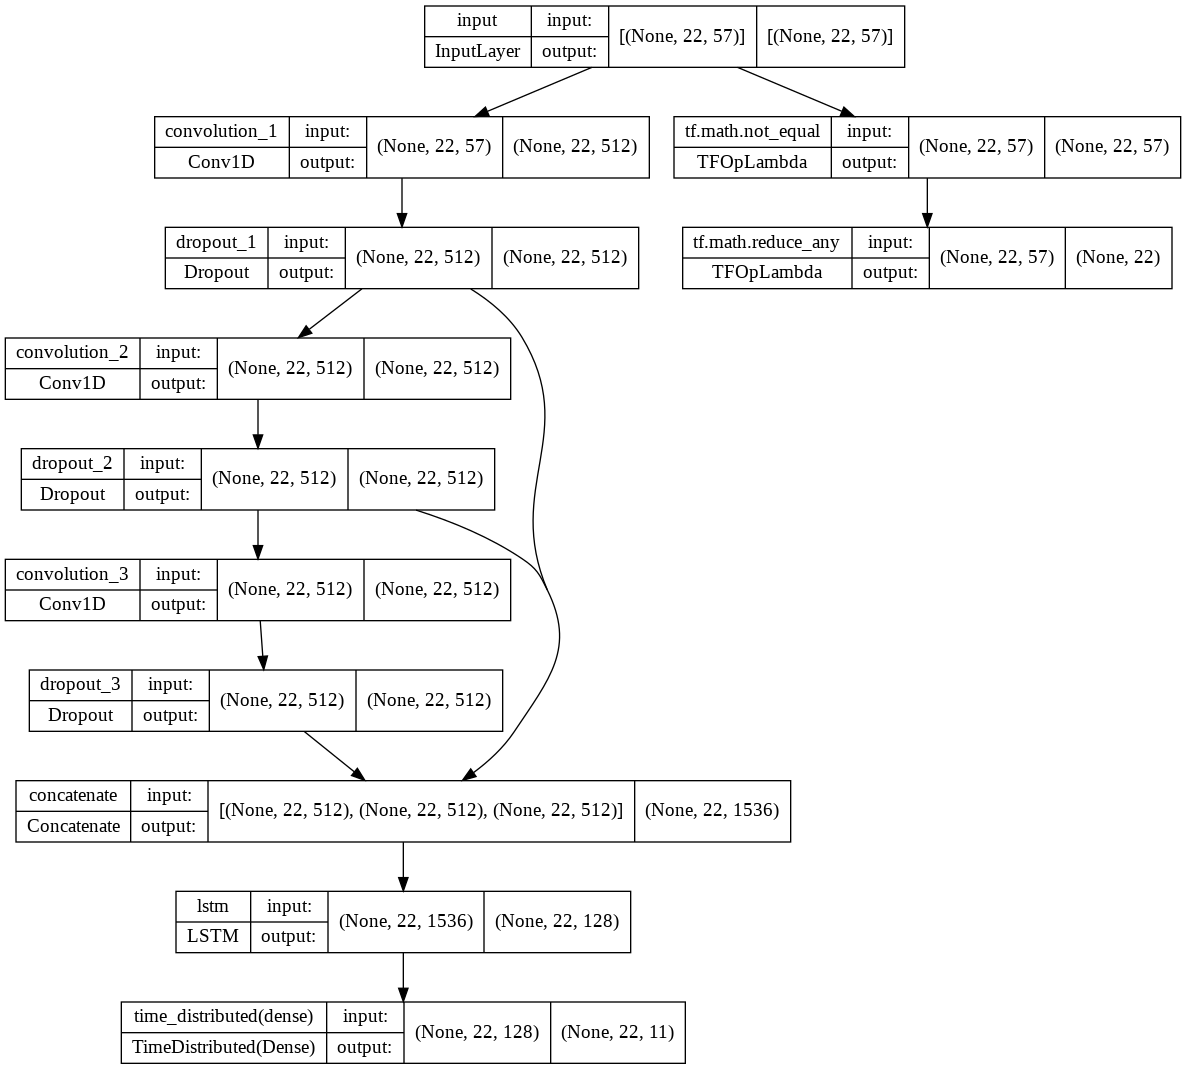

In [ ]:
import io
from tensorflow.keras.utils import plot_model

model = MorphemModel([0.4, 0.4, 0.4], [512, 512, 512], 1, 60, 0.1, [5, 5, 5], MAX_LEN)
model_path = "/content/drive/MyDrive/morph_model/new_lstm128.h5"
    #"/content/drive/MyDrive/morph_model/new_attention32_withoutPos_withoutConcat.h5"
    # "/content/drive/MyDrive/morph_model/attention32_checkpoint.h5"
    # "/content/drive/MyDrive/morph_model/attention32.h5"
    # "/content/drive/MyDrive/morph_model/lstm128_checkpoint.h5"
model.load(model_path)


def get_model_summary(model):
    stream = io.StringIO()
    model.models[-1].summary(print_fn=lambda x: stream.write(x + '\n'))
    summary_string = stream.getvalue()
    stream.close()
    return summary_string

model_summary_string = get_model_summary(model)
print(model_summary_string)

plot_model(model.models[-1], to_file='/content/drive/MyDrive/morph_model/model_plot.png', show_shapes=True, show_layer_names=True)

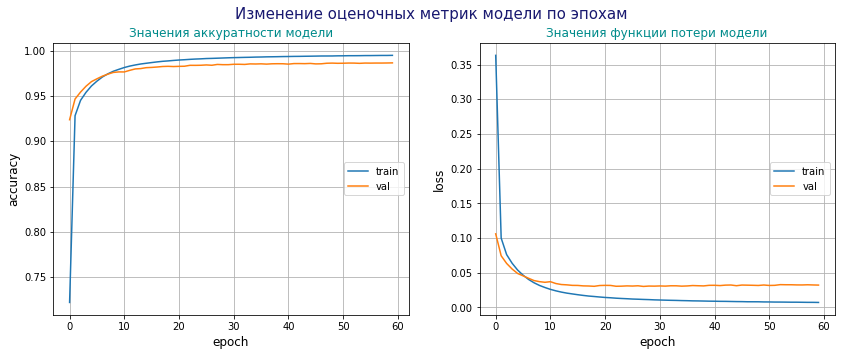

<Figure size 432x288 with 0 Axes>

In [ ]:
from matplotlib import pyplot as plt


plt.figure(figsize=(14,5))

plt.suptitle('Изменение оценочных метрик модели по эпохам', fontsize=15, color='midnightblue')

plt.subplot(1, 2, 1) 
plt.title('Значения аккуратности модели',fontsize=12, c='darkcyan')
#plt.plot(x_val, y_val, linestyle='-', marker='.', color='b')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['train', 'val'], loc='center right')
plt.grid(True) 

plt.subplot(1, 2, 2)
plt.title('Значения функции потери модели',fontsize=12, c='darkcyan')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['train', 'val'], loc='center right')
plt.grid(True) 

plt.show()
plt.savefig('/content/drive/MyDrive/morph_model/model_metrics1.png')

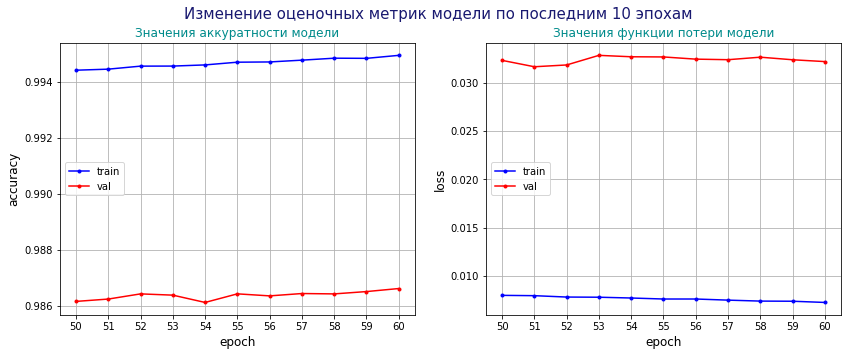

<Figure size 432x288 with 0 Axes>

In [ ]:
from matplotlib import pyplot as plt


plt.figure(figsize=(14,5))

plt.suptitle('Изменение оценочных метрик модели по последним 10 эпохам', fontsize=15, color='midnightblue')

plt.subplot(1, 2, 1) 
plt.title('Значения аккуратности модели', fontsize=12, c='darkcyan')
#plt.plot(x_val, y_val, linestyle='-', marker='.', color='b')
plt.plot(history.history['acc'][49:], marker='.', color='b')
plt.plot(history.history['val_acc'][49:], marker='.', color='r')
plt.ylabel('accuracy', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.xticks(range(0, 11), range(50, 61), fontsize=10)
plt.legend(['train', 'val'], loc='center left')
plt.grid(True) 

plt.subplot(1, 2, 2)
plt.title('Значения функции потери модели',fontsize=12, c='darkcyan')
plt.plot(history.history['loss'][49:], marker='.', color='b')
plt.plot(history.history['val_loss'][49:], marker='.', color='r')
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.xticks(range(0, 11), range(50, 61), fontsize=10)
plt.legend(['train', 'val'], loc='center left')
plt.grid(True) 

plt.show()
plt.savefig('/content/drive/MyDrive/morph_model/model_metrics11.png')

In [ ]:
from collections import defaultdict

def get_history_from_output():
    history = defaultdict(list)
    for line in input().split('Epoch')[1:]:
        metrics = line.split('-')[-4:]
        for metric in metrics:
            metric_name, metric_value = metric.split(':')
            metric_name = metric_name.strip()
            metric_value = float(metric_value)
            history[metric_name].append(metric_value)
    return history

history32 = get_history_from_output()
history64 = get_history_from_output()
history128 = get_history_from_output()

Epoch 1/60 277/277 [==============================] - 300s 1s/step - loss: 0.3632 - acc: 0.7219 - val_loss: 0.1060 - val_acc: 0.9238 Epoch 2/60 277/277 [==============================] - 284s 1s/step - loss: 0.0999 - acc: 0.9283 - val_loss: 0.0745 - val_acc: 0.9467 Epoch 3/60 277/277 [==============================] - 284s 1s/step - loss: 0.0761 - acc: 0.9452 - val_loss: 0.0634 - val_acc: 0.9543 Epoch 4/60 277/277 [==============================] - 284s 1s/step - loss: 0.0637 - acc: 0.9541 - val_loss: 0.0554 - val_acc: 0.9608 Epoch 5/60 277/277 [==============================] - 284s 1s/step - loss: 0.0540 - acc: 0.9611 - val_loss: 0.0490 - val_acc: 0.9659 Epoch 6/60 277/277 [==============================] - 284s 1s/step - loss: 0.0466 - acc: 0.9664 - val_loss: 0.0455 - val_acc: 0.9690 Epoch 7/60 277/277 [==============================] - 284s 1s/step - loss: 0.0404 - acc: 0.9711 - val_loss: 0.0421 - val_acc: 0.9720 Epoch 8/60 277/277 [==============================] - 284s 1s/step - 

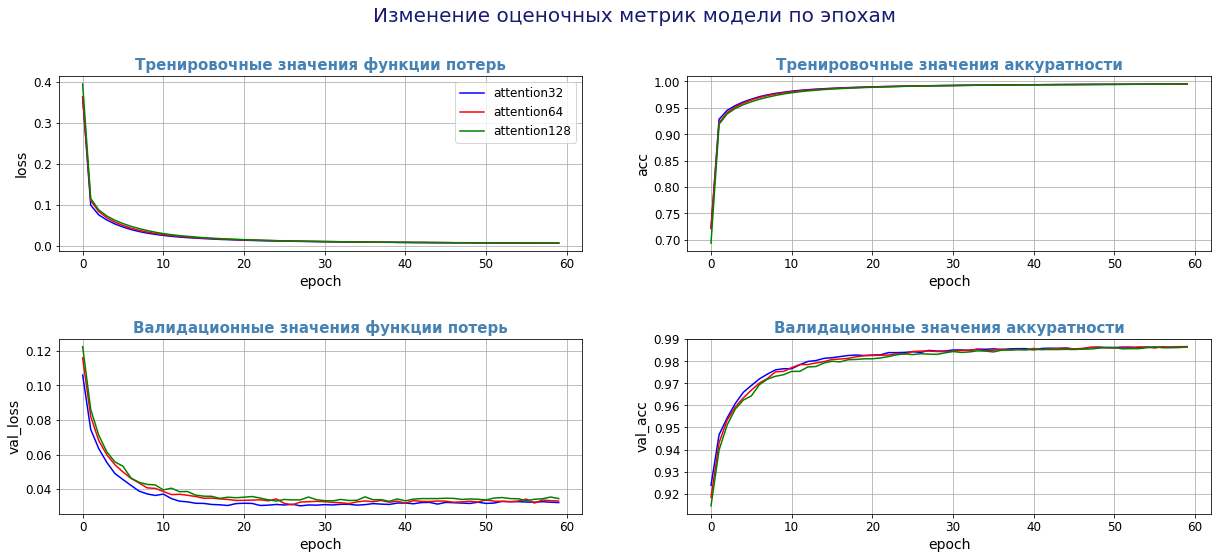

In [ ]:
from matplotlib import pyplot as plt


plt.figure(figsize=(20,8))
plt.suptitle('Изменение оценочных метрик модели по эпохам', fontsize=20, color='midnightblue')

metrics = dict(zip(history32.keys(), ['Тренировочные значения функции потерь', 'Тренировочные значения аккуратности',
                                      'Валидационные значения функции потерь', 'Валидационные значения аккуратности']))

for i, key in enumerate(history32):
    plt.subplot(2, 2, i+1) 
    plt.title(metrics[key], fontsize=15, c='steelblue', fontweight='bold')
    #plt.plot(x_val, y_val, linestyle='-', marker='.', color='b')
    plt.plot(history32[key], color='b')
    plt.plot(history64[key], color='r')
    plt.plot(history128[key], color='g')
    plt.ylabel(key, fontsize=14)
    plt.xlabel('epoch', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if i == 0:
        plt.legend(['attention32', 'attention64', 'attention128'], loc='upper right', fontsize=12)
    plt.grid(True) 

#plt.tight_layout(pad=3.0)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.86, wspace=0.2, hspace=0.5)
#plt.show()
plt.savefig('/content/drive/MyDrive/morph_model/model_metrics4.png')

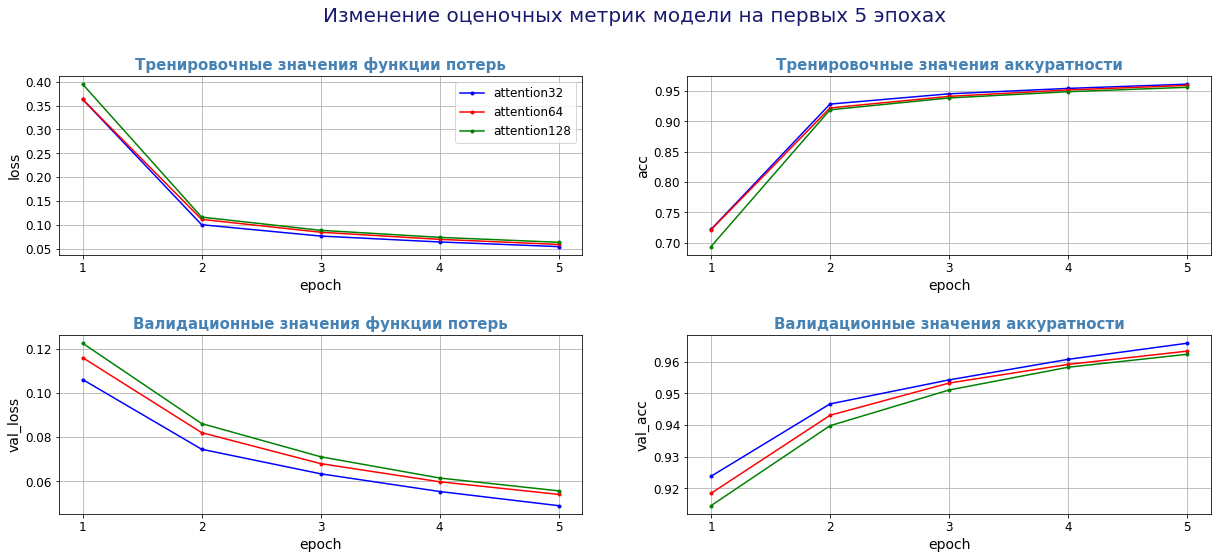

In [ ]:
from matplotlib import pyplot as plt


plt.figure(figsize=(20,8))
plt.suptitle('Изменение оценочных метрик модели на первых 5 эпохах', fontsize=20, color='midnightblue')

metrics = dict(zip(history32.keys(), ['Тренировочные значения функции потерь', 'Тренировочные значения аккуратности',
                                      'Валидационные значения функции потерь', 'Валидационные значения аккуратности']))

for i, key in enumerate(history32):
    plt.subplot(2, 2, i+1) 
    plt.title(metrics[key], fontsize=15, c='steelblue', fontweight='bold')
    #plt.plot(x_val, y_val, linestyle='-', marker='.', color='b')
    plt.plot(history32[key][:5], marker='.', color='b')
    plt.plot(history64[key][:5], marker='.', color='r')
    plt.plot(history128[key][:5], marker='.', color='g')
    plt.ylabel(key, fontsize=14)
    plt.xlabel('epoch', fontsize=14)
    plt.xticks(range(0, 5), range(1, 6), fontsize=12)
    plt.yticks(fontsize=12)
    if i == 0:
        plt.legend(['attention32', 'attention64', 'attention128'], loc='upper right', fontsize=12)
    plt.grid(True) 

#plt.tight_layout(pad=3.0)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.86, wspace=0.2, hspace=0.45)
#plt.show()
plt.savefig('/content/drive/MyDrive/morph_model/model_metrics444.png')

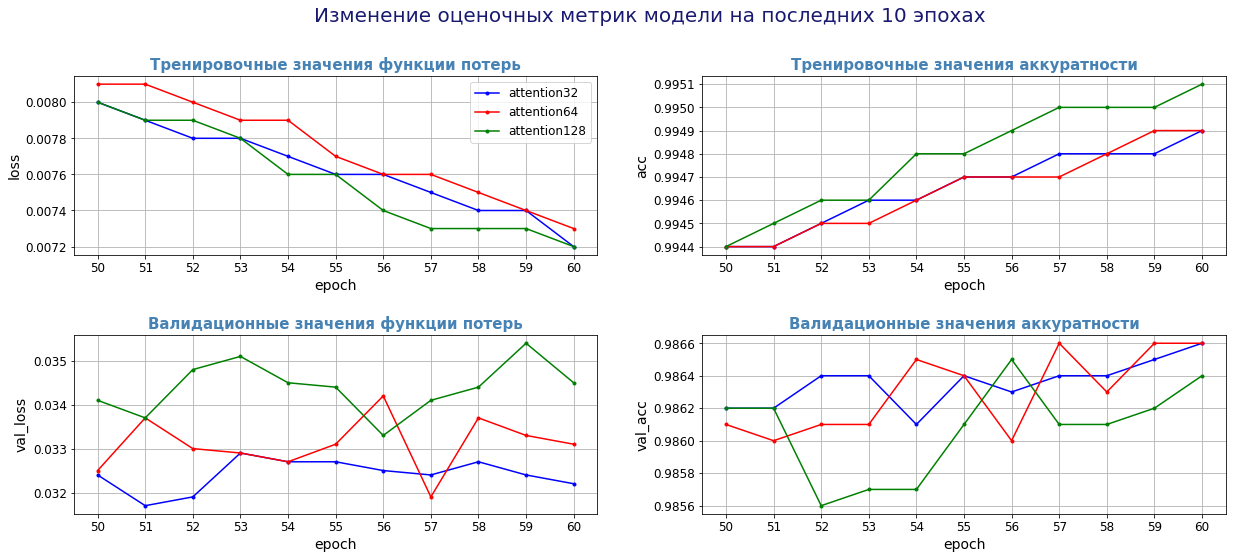

In [ ]:
from matplotlib import pyplot as plt


plt.figure(figsize=(20,8))
plt.suptitle('Изменение оценочных метрик модели на последних 10 эпохах', fontsize=20, color='midnightblue')

metrics = dict(zip(history32.keys(), ['Тренировочные значения функции потерь', 'Тренировочные значения аккуратности',
                                      'Валидационные значения функции потерь', 'Валидационные значения аккуратности']))

for i, key in enumerate(history32):
    plt.subplot(2, 2, i+1) 
    plt.title(metrics[key], fontsize=15, c='steelblue', fontweight='bold')
    #plt.plot(x_val, y_val, linestyle='-', marker='.', color='b')
    plt.plot(history32[key][49:], marker='.', color='b')
    plt.plot(history64[key][49:], marker='.', color='r')
    plt.plot(history128[key][49:], marker='.', color='g')
    plt.ylabel(key, fontsize=14)
    plt.xlabel('epoch', fontsize=14)
    plt.xticks(range(0, 11), range(50, 61), fontsize=12)
    plt.yticks(fontsize=12)
    if i == 0:
        plt.legend(['attention32', 'attention64', 'attention128'], loc='upper right', fontsize=12)
    plt.grid(True) 

#plt.tight_layout(pad=3.0)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.86, wspace=0.2, hspace=0.45)
#plt.show()
plt.savefig('/content/drive/MyDrive/morph_model/model_metrics44.png')